# Problem : Overfitting and Underfitting

When we compare the training and validation errors, we want to be mindful of two common situations.
If the model is unable to reduce the training error, that could mean that our model is too simple (i.e., insufficiently expressive) to capture the pattern that we are trying to model.

On the other hand, we want to watch out for the cases when our training error is significantly lower than our validation error, indicating severe overfitting.


In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display


def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


class Accumulator:  # @save
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch_ch3(net, train_iter, loss, updater):  # @save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)  # Each pair has 3 elements
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:  # @save
    """For plotting data in animation."""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  # @save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


## Polynomial Regression

Generate data 𝑦 = 5+1.2*𝑥 − 3.4*𝑥^2/2! + 5.6\*𝑥^3/3! + 𝜖 where 𝜖∼N(0,0.1^2).


## Data

To illustrate some classical intuition about overfitting and model complexity, consider the following: given training data consisting of a single feature x and a corresponding real-valued label y, we try to find the polynomial of degree d.


In [2]:
max_degree = 30  # Maximum degree of the polynomial
n_train, n_test = 200, 200  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))  # x
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)   # y
labels += np.random.normal(scale=0.1, size=labels.shape)  # add noise


In [3]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]


(tensor([[-1.1168],
         [ 1.0763]]),
 tensor([[ 1.0000e+00, -1.1168e+00,  6.2358e-01, -2.3213e-01,  6.4808e-02,
          -1.4475e-02,  2.6942e-03, -4.2982e-04,  6.0001e-05, -7.4452e-06,
           8.3145e-07, -8.4412e-08,  7.8557e-09, -6.7484e-10,  5.3831e-11,
          -4.0077e-12,  2.7973e-13, -1.8376e-14,  1.1401e-15, -6.7011e-17,
           3.7417e-18, -1.9898e-19,  1.0101e-20, -4.9044e-22,  2.2821e-23,
          -1.0194e-24,  4.3786e-26, -1.8111e-27,  7.2233e-29, -2.7816e-30],
         [ 1.0000e+00,  1.0763e+00,  5.7924e-01,  2.0782e-01,  5.5920e-02,
           1.2038e-02,  2.1594e-03,  3.3204e-04,  4.4673e-05,  5.3425e-06,
           5.7503e-07,  5.6265e-08,  5.0467e-09,  4.1784e-10,  3.2124e-11,
           2.3050e-12,  1.5506e-13,  9.8174e-15,  5.8704e-16,  3.3255e-17,
           1.7897e-18,  9.1728e-20,  4.4877e-21,  2.1001e-22,  9.4184e-24,
           4.0549e-25,  1.6786e-26,  6.6917e-28,  2.5723e-29,  9.5471e-31]]),
 tensor([0.1431, 5.2958]))

## Loss function


In [4]:
def evaluate_loss(net, data_iter, loss):  # @save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


## Define training process


In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


## Use the first four dimensions features


weight: [[ 4.9985256  1.2160599 -3.4077125  5.5720286]]


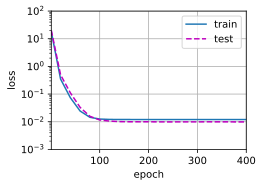

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])


## Use the first two dimensions features (Underfitting)


weight: [[3.2932909 4.0348935]]


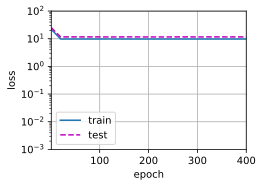

In [7]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])


## Use all dimension features (Overfitting)


weight: [[ 5.0052638e+00  1.2728375e+00 -3.4418039e+00  5.2834840e+00
   5.0087858e-02  8.0213505e-01  1.3815196e-01 -8.2989067e-02
   1.1586751e-01 -5.4217130e-03 -7.3147520e-02 -1.3034140e-01
   1.1172615e-01 -1.3277854e-01  9.3434073e-02  4.0583573e-02
  -3.1483166e-03 -1.0660329e-01 -6.3259065e-02  1.4569312e-02
   1.3501488e-01 -1.8075123e-01 -9.5696546e-02  7.0112526e-02
  -1.3731210e-01 -1.0615379e-01 -1.7502844e-01  1.7459644e-02
  -6.4369932e-02  1.5065870e-02]]


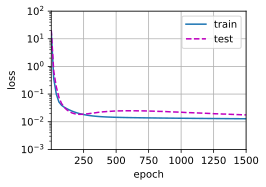

In [8]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)


# Solution 1: Weight Decay (commonly called 𝐿2 regularization)

Now that we have characterized the problem of overfitting, we can introduce our first regularization technique.
Rather than directly manipulating the number of parameters, weight decay, operates by restricting the values that the parameters can take.


In [9]:
import torch
from torch import nn
from d2l import torch as d2l


In [10]:
# 20 training data with dimension 200
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)


In [11]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]


In [12]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2     # square all terms in place and sum them up


In [13]:
def train(lambd):        # lambd control whether we use L2 regularization
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())


L2 norm of w: 13.752131462097168


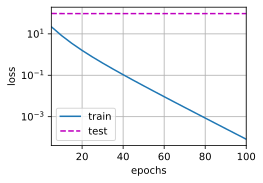

In [14]:
train(lambd=0)


L2 norm of w: 0.3681052625179291


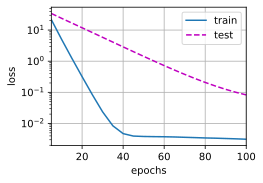

In [15]:
train(lambd=3)


## Concise Implementation


In [16]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([
        {"params": net[0].weight, 'weight_decay': wd},
        {"params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())


L2 norm of w: 13.567094802856445


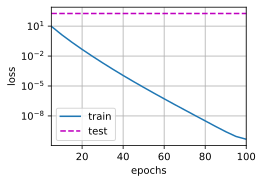

In [17]:
train_concise(0)


L2 norm of w: 0.37077999114990234


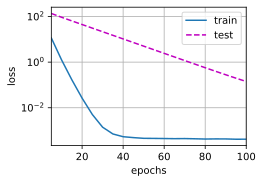

In [18]:
train_concise(3)


# Solution 2: Dropout

When we apply dropout to a hidden layer, zeroing out each hidden unit with probability p
, the result can be viewed as a network containing only a subset of the original neurons. Typically, we disable dropout at test time. Given a trained model and a new example, we do not drop out any nodes and thus do not need to normalize.


In [19]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)


In [20]:
X = 10
dropout = 0.9
mask = (torch.rand(X) > dropout).float()
mask


tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))


tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  8., 10.,  0.,  0.],
        [16., 18., 20., 22., 24., 26., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


## Define MLP with two hidden layers, each have 256 nodes


In [22]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.5, 0.5


class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)


## Training and testing


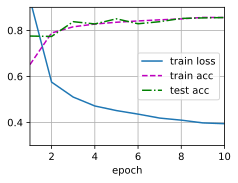

In [23]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)   # Also fashion mnist data
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


## Concise Implementation


In [24]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the first fully connected layer
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the second fully connected layer
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weights)


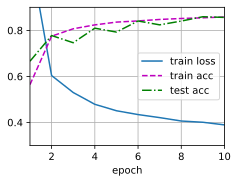

In [25]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
